# HW 3 - Tushar Jain

## Module imports and setup

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import math
from pandas.plotting import scatter_matrix, lag_plot, autocorrelation_plot

In [2]:
%matplotlib inline

## Data ingestion

In [3]:
df = pd.read_csv('../../../Lectures/Lecture 3/data/hw3.csv')
df.head()

,ts,open,high,low,close,volume,volumeUSD,token,chain
0,2021-12-02 14:00:00,22.4150,22.4913,22.0816,22.3516,31502.151631,NaN,UNI,ETH
1,2021-12-02 23:00:00,4.8043,4.8043,4.7426,4.7806,73686.230000,NaN,CRV,ETH
2,2021-12-10 15:00:00,182.4900,NaN,175.2100,175.8600,73736.747000,NaN,SOL,SOL
3,2021-12-10 18:00:00,3978.4300,3989.7400,3932.0000,3972.3400,18508.040102,NaN,ETH,ETH
4,2021-12-08 21:00:00,193.3240,194.2420,192.5640,193.1540,69426.909000,NaN,SOL,SOL


In [4]:
df['ts'] = pd.to_datetime(df['ts'])
df.head()

,ts,open,high,low,close,volume,volumeUSD,token,chain
0,2021-12-02 14:00:00,22.4150,22.4913,22.0816,22.3516,31502.151631,NaN,UNI,ETH
1,2021-12-02 23:00:00,4.8043,4.8043,4.7426,4.7806,73686.230000,NaN,CRV,ETH
2,2021-12-10 15:00:00,182.4900,NaN,175.2100,175.8600,73736.747000,NaN,SOL,SOL
3,2021-12-10 18:00:00,3978.4300,3989.7400,3932.0000,3972.3400,18508.040102,NaN,ETH,ETH
4,2021-12-08 21:00:00,193.3240,194.2420,192.5640,193.1540,69426.909000,NaN,SOL,SOL


In [5]:
df = df.sort_values(by='ts')
df = df.set_index('ts')
df.head(10)

,open,high,low,close,volume,volumeUSD,token,chain
ts,,,,,,,,
2021-12-01 00:00:00,210.3120,NaN,208.4320,208.676000,7.003162e+04,NaN,SOL,SOL
2021-12-01 00:00:00,280.5900,281.4000,278.3000,278.700000,2.078490e+02,NaN,COMP,ETH
2021-12-01 00:00:00,257.1020,260.7750,255.3450,257.078000,2.730299e+03,NaN,AAVE,ETH
2021-12-01 00:00:00,21.2004,21.3115,21.0337,21.265900,1.240613e+04,NaN,UNI,ETH
2021-12-01 00:00:00,57321.4100,57451.0500,56814.3400,56987.970000,3.884820e+02,NaN,BTC,BTC
2021-12-01 00:00:00,4656.6200,4672.4300,4624.1600,4634.950000,6.013007e+03,NaN,ETH,ETH
2021-12-01 00:00:00,1.0008,1.0009,1.0008,1.000800,1.588402e+06,NaN,USDT,USDT
2021-12-01 00:00:00,4.8830,5.0723,4.8264,0.050295,3.395810e+05,NaN,CRV,ETH
2021-12-01 01:00:00,4636.4300,4736.9000,4605.4900,4729.100000,1.381906e+04,NaN,ETH,ETH


In [6]:
df.shape

(2667, 8)

## Clean Up

### Drop duplicates

In [7]:
df = df.drop_duplicates()
df.shape

(2360, 8)

### Fix the token column

In [8]:
df.token.value_counts()

COMP                                  286
BTC                                   283
SOL                                   281
AAVE                                  280
CRV                                   279
USDT                                  278
UNI                                   270
ETH                                   270
<span name="tokenName">ETH</span>      25
<span name="tokenName">UNI</span>      25
<span name="tokenName">USDT</span>     17
<span name="tokenName">CRV</span>      16
<span name="tokenName">AAVE</span>     15
<span name="tokenName">SOL</span>      14
<span name="tokenName">BTC</span>      12
<span name="tokenName">COMP</span>      9
Name: token, dtype: int64

In [9]:
df['token'] = df['token'].mask(df['token'].str.contains('span'), df['token'].str.extract(r'<span.*?>(.*?)</span>', expand=False))
df['token'].value_counts()

SOL     295
COMP    295
AAVE    295
UNI     295
BTC     295
ETH     295
USDT    295
CRV     295
Name: token, dtype: int64

In [10]:
df.shape

(2360, 8)

### Fixing close price

#### 1. Cleaning up outliers

In [11]:
def create_graphs(df, columns):
    fig, axes = plt.subplots(nrows=math.ceil(df.token.nunique()/2.0), 
                             ncols=2, 
                             figsize=(10, 6*(math.ceil(df.token.nunique()/2.0))))

    line_styles = ["-","--",":","-."]
    for idx, (token, df_token) in enumerate(df[['token'] + list(columns)].groupby('token')):
        ax = axes[idx//2, idx%2]
        for col_idx, col in enumerate(columns):
            df_token[col].plot(ax=ax, label=f'{token}_{col}', style=line_styles[col_idx % len(line_styles)])
        ax.legend()

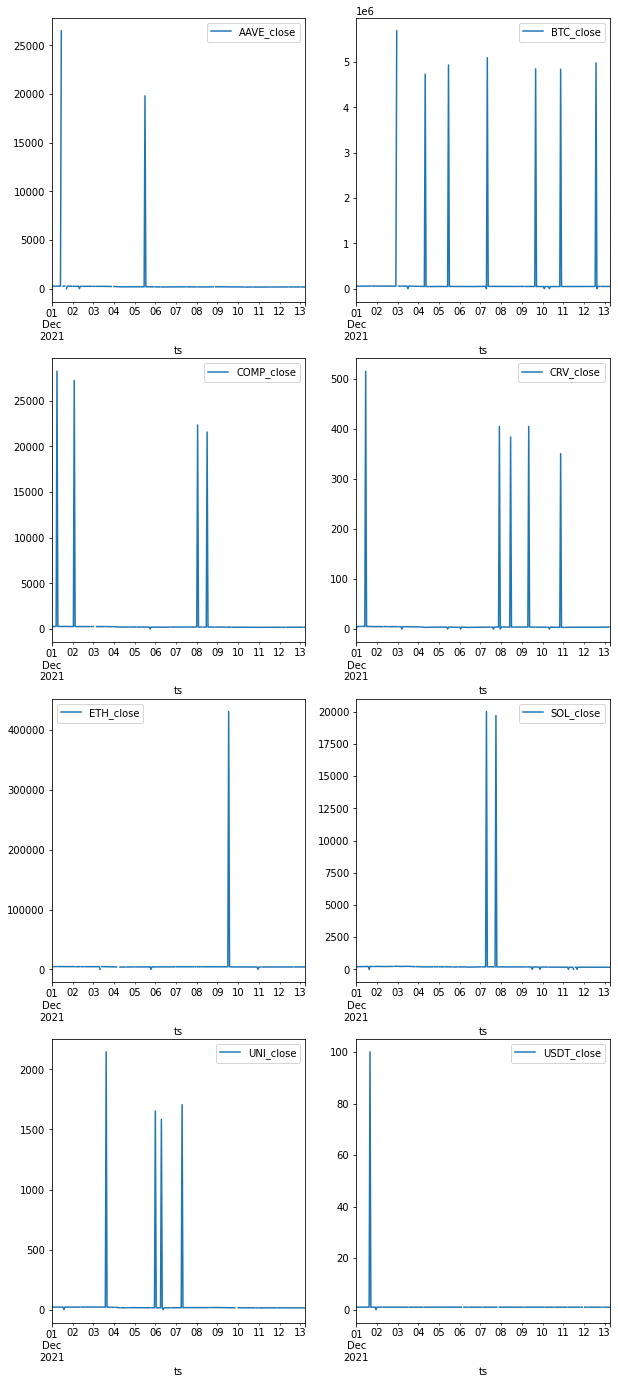

In [12]:
create_graphs(df, ('close',))

In [13]:
for token in df.token.unique():
    df.loc[df['token']==token, 'next_open'] = df.loc[df['token']==token, 'open'].shift(-1)
df.head(10)

,open,high,low,close,volume,volumeUSD,token,chain,next_open
ts,,,,,,,,,
2021-12-01 00:00:00,210.3120,NaN,208.4320,208.676000,7.003162e+04,NaN,SOL,SOL,208.7160
2021-12-01 00:00:00,280.5900,281.4000,278.3000,278.700000,2.078490e+02,NaN,COMP,ETH,278.6500
2021-12-01 00:00:00,257.1020,260.7750,255.3450,257.078000,2.730299e+03,NaN,AAVE,ETH,257.1490
2021-12-01 00:00:00,21.2004,21.3115,21.0337,21.265900,1.240613e+04,NaN,UNI,ETH,21.2660
2021-12-01 00:00:00,57321.4100,57451.0500,56814.3400,56987.970000,3.884820e+02,NaN,BTC,BTC,56998.3500
2021-12-01 00:00:00,4656.6200,4672.4300,4624.1600,4634.950000,6.013007e+03,NaN,ETH,ETH,4636.4300
2021-12-01 00:00:00,1.0008,1.0009,1.0008,1.000800,1.588402e+06,NaN,USDT,USDT,1.0008
2021-12-01 00:00:00,4.8830,5.0723,4.8264,0.050295,3.395810e+05,NaN,CRV,ETH,5.0311
2021-12-01 01:00:00,4636.4300,4736.9000,4605.4900,4729.100000,1.381906e+04,NaN,ETH,ETH,4729.1000


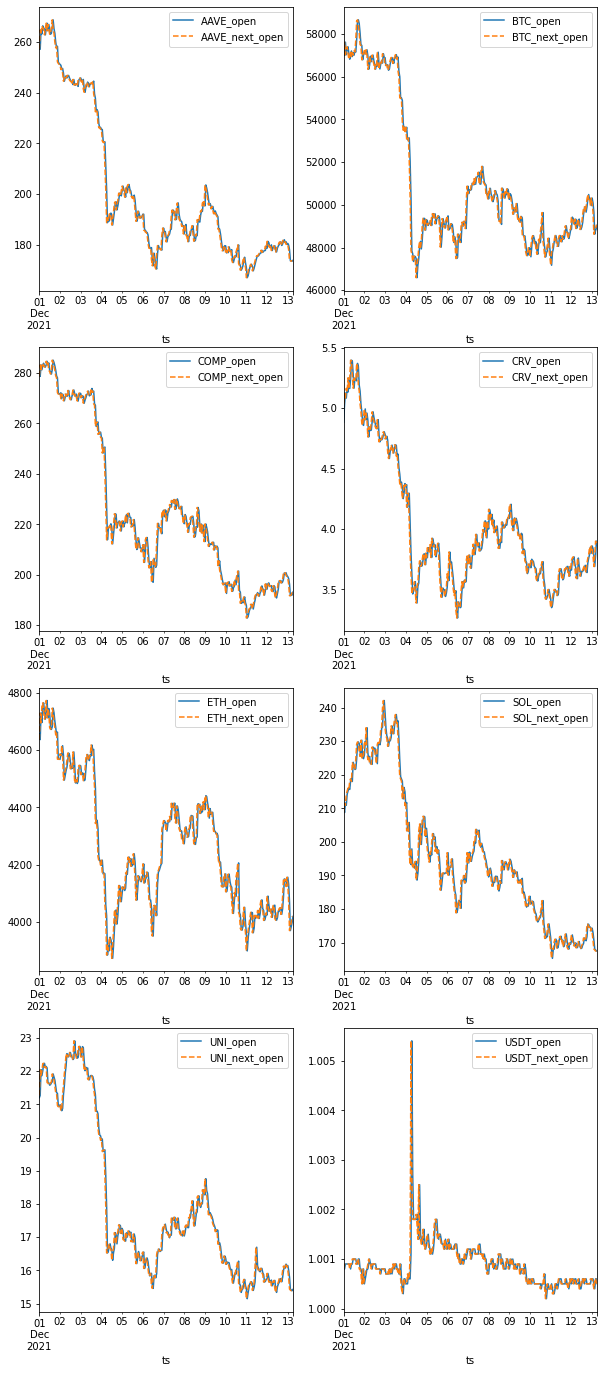

In [14]:
create_graphs(df, ('open','next_open'))

In [15]:
df[df['close']/df['open'] > 2.0]

,open,high,low,close,volume,volumeUSD,token,chain,next_open
ts,,,,,,,,,
2021-12-01 06:00:00,282.6500,283.7300,282.0000,28222.00,3.701940e+02,NaN,COMP,ETH,282.3000
2021-12-01 11:00:00,266.9360,267.9630,264.2370,26501.50,1.018631e+03,NaN,AAVE,ETH,264.9130
2021-12-01 11:00:00,5.2728,5.2882,5.1510,516.10,2.459183e+05,NaN,CRV,ETH,5.1651
2021-12-01 16:00:00,1.0009,NaN,1.0009,100.10,5.186434e+06,NaN,USDT,USDT,1.0010
2021-12-02 02:00:00,269.7800,272.1200,268.2900,27212.00,4.564180e+02,NaN,COMP,ETH,271.6200
2021-12-02 23:00:00,56904.6500,56952.8100,56639.4900,5688883.00,3.821792e+02,NaN,BTC,BTC,56888.8300
2021-12-03 15:00:00,21.7247,21.7884,21.4125,2145.88,2.317697e+04,NaN,UNI,ETH,21.4586
2021-12-04 08:00:00,47711.3400,47869.7300,46750.0000,4734782.00,1.661132e+03,NaN,BTC,BTC,47347.8100
2021-12-05 11:00:00,49113.5500,NaN,NaN,4936795.00,6.211598e+02,NaN,BTC,BTC,49368.0500


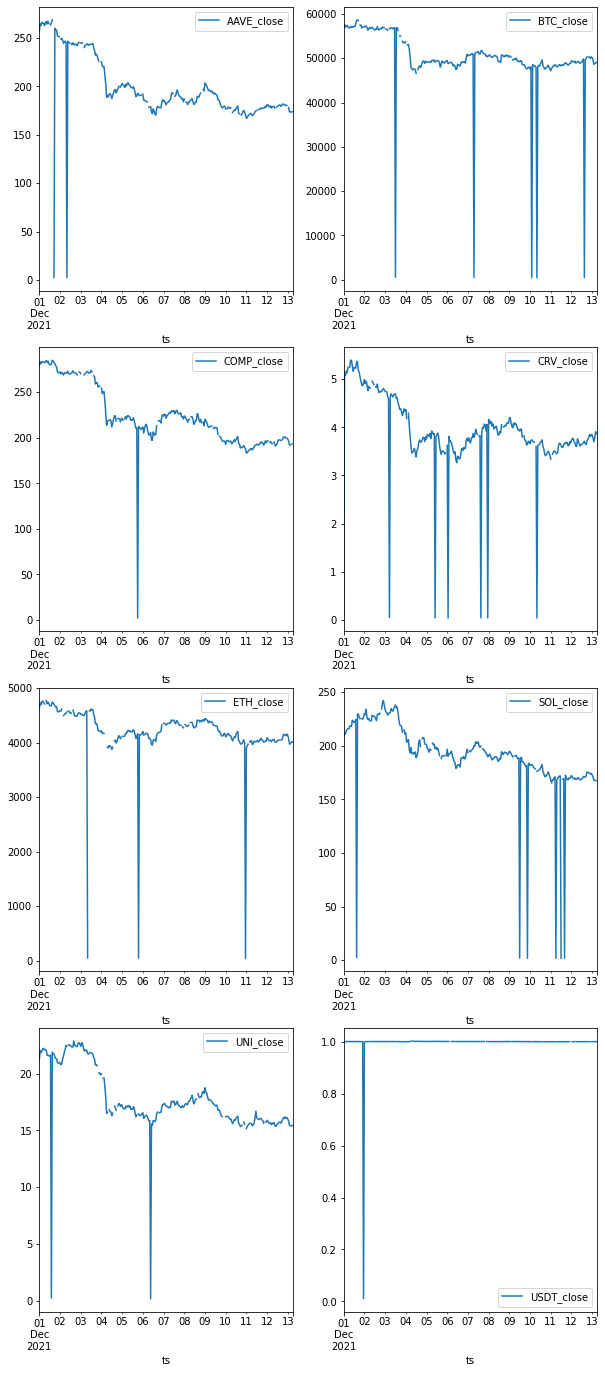

In [16]:
df['close'] = df['close'].mask(df['close']/df['open'] > 2.0, df['next_open'])
create_graphs(df, ('close', ))

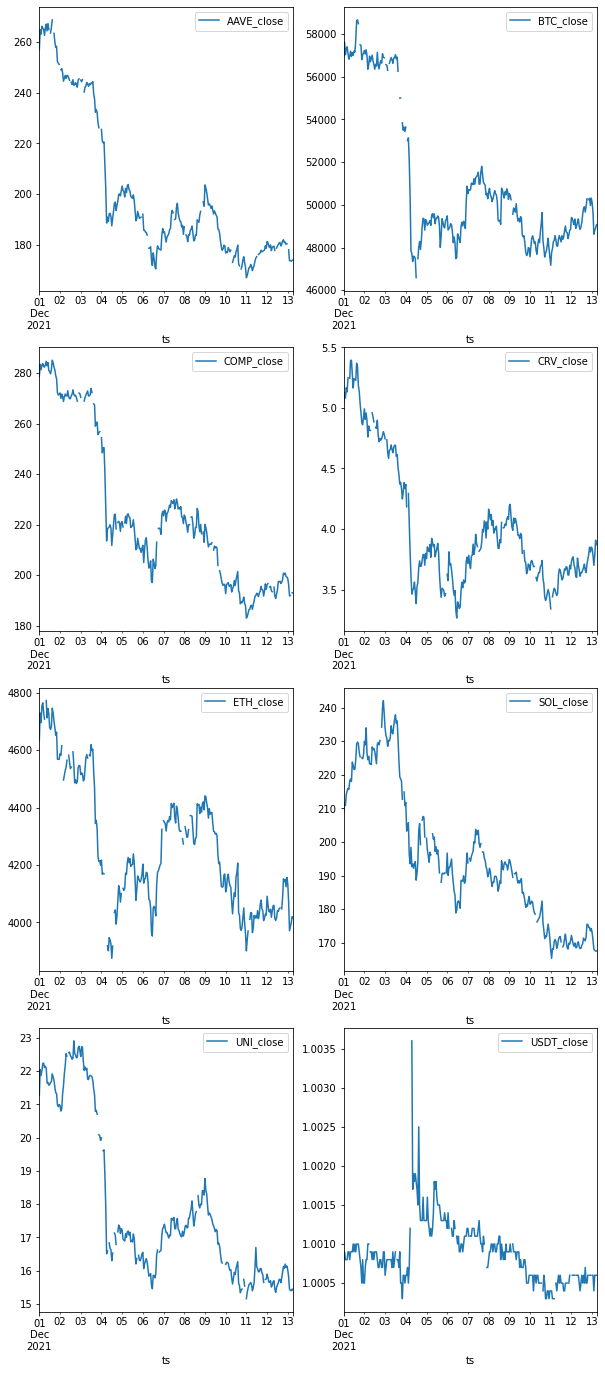

In [17]:
df['close'] = df['close'].mask(df['close']/df['open'] < 0.5, df['next_open'])
create_graphs(df, ('close', ))

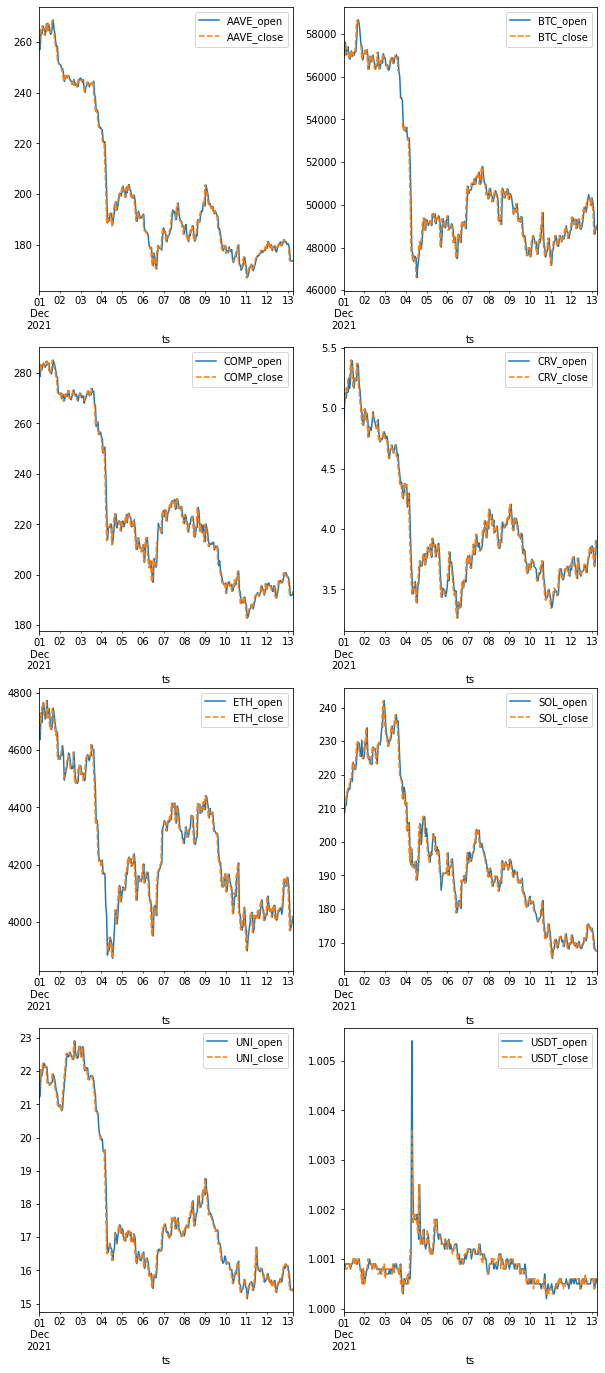

In [18]:
create_graphs(df, ('open', 'close',))

In [19]:
df = df.drop('next_open', axis=1)
df.head()

,open,high,low,close,volume,volumeUSD,token,chain
ts,,,,,,,,
2021-12-01,210.3120,NaN,208.4320,208.6760,70031.618000,NaN,SOL,SOL
2021-12-01,280.5900,281.4000,278.3000,278.7000,207.849000,NaN,COMP,ETH
2021-12-01,257.1020,260.7750,255.3450,257.0780,2730.299000,NaN,AAVE,ETH
2021-12-01,21.2004,21.3115,21.0337,21.2659,12406.133674,NaN,UNI,ETH
2021-12-01,57321.4100,57451.0500,56814.3400,56987.9700,388.482022,NaN,BTC,BTC


#### 2. Cleaning up NaNs

In [20]:
df.shape

(2360, 8)

In [21]:
df.loc[df['close'].isnull()]

,open,high,low,close,volume,volumeUSD,token,chain
ts,,,,,,,,
2021-12-01 06:00:00,5.2505,5.3002,5.1566,NaN,3.897987e+05,NaN,CRV,ETH
2021-12-01 07:00:00,4707.7400,4750.0000,4691.6200,NaN,8.911032e+03,NaN,ETH,ETH
2021-12-01 12:00:00,264.9130,264.9260,261.8000,NaN,1.019545e+03,NaN,AAVE,ETH
2021-12-01 16:00:00,268.7450,269.1060,264.8280,NaN,2.063599e+03,NaN,AAVE,ETH
2021-12-01 18:00:00,58485.8800,58631.4000,58007.2400,NaN,6.332399e+02,NaN,BTC,BTC
...,...,...,...,...,...,...,...,...
2021-12-12 20:00:00,1.0005,NaN,1.0005,NaN,1.258771e+06,NaN,USDT,USDT
2021-12-12 23:00:00,1.0006,NaN,1.0005,NaN,8.614092e+05,NaN,USDT,USDT
2021-12-13 00:00:00,180.5100,181.1900,NaN,NaN,1.016050e+03,NaN,AAVE,ETH


##### 1. If high and low are available, set close as average of those

In [22]:
df['close'] = df['close'].mask(df['close'].isnull(), 0.5*(df['high'] + df['low']))
df.loc[df['close'].isnull()]

,open,high,low,close,volume,volumeUSD,token,chain
ts,,,,,,,,
2021-12-02 00:00:00,251.1620,NaN,250.0750,NaN,8.301560e+02,NaN,AAVE,ETH
2021-12-02 14:00:00,4540.3000,4546.3000,NaN,NaN,4.468941e+03,NaN,ETH,ETH
2021-12-03 01:00:00,270.1900,271.8700,NaN,NaN,1.999890e+02,NaN,COMP,ETH
2021-12-03 13:00:00,1.0009,NaN,1.0008,NaN,1.010927e+06,NaN,USDT,USDT
2021-12-03 16:00:00,56259.0400,NaN,55730.9300,NaN,1.394131e+03,NaN,BTC,BTC
2021-12-03 23:00:00,226.3090,NaN,224.5400,NaN,1.362667e+03,NaN,AAVE,ETH
2021-12-03 23:00:00,256.5500,NaN,254.2700,NaN,5.700690e+02,NaN,COMP,ETH
2021-12-04 01:00:00,19.9560,NaN,19.5569,NaN,7.099149e+04,NaN,UNI,ETH
2021-12-04 01:00:00,53633.0200,NaN,53027.0100,NaN,8.411414e+02,NaN,BTC,BTC


##### 2. Remove all other entries with close as NaN

In [23]:
df = df.dropna(subset=['close'])
df.shape

(2327, 8)

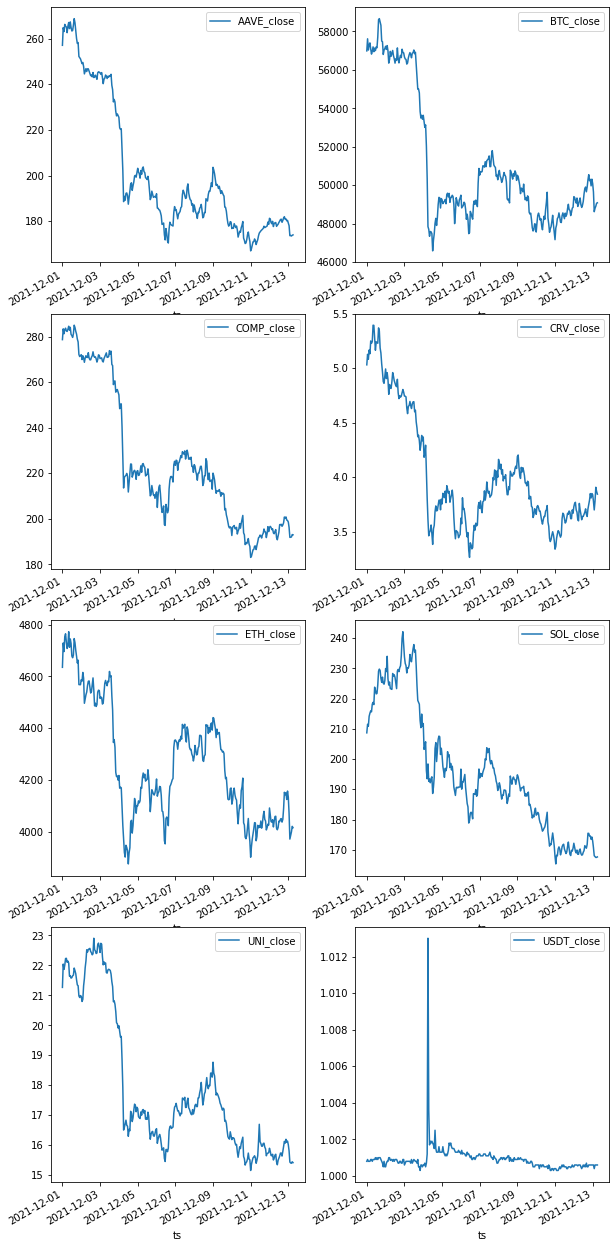

In [24]:
create_graphs(df, ('close', ))

### Fixing Volume

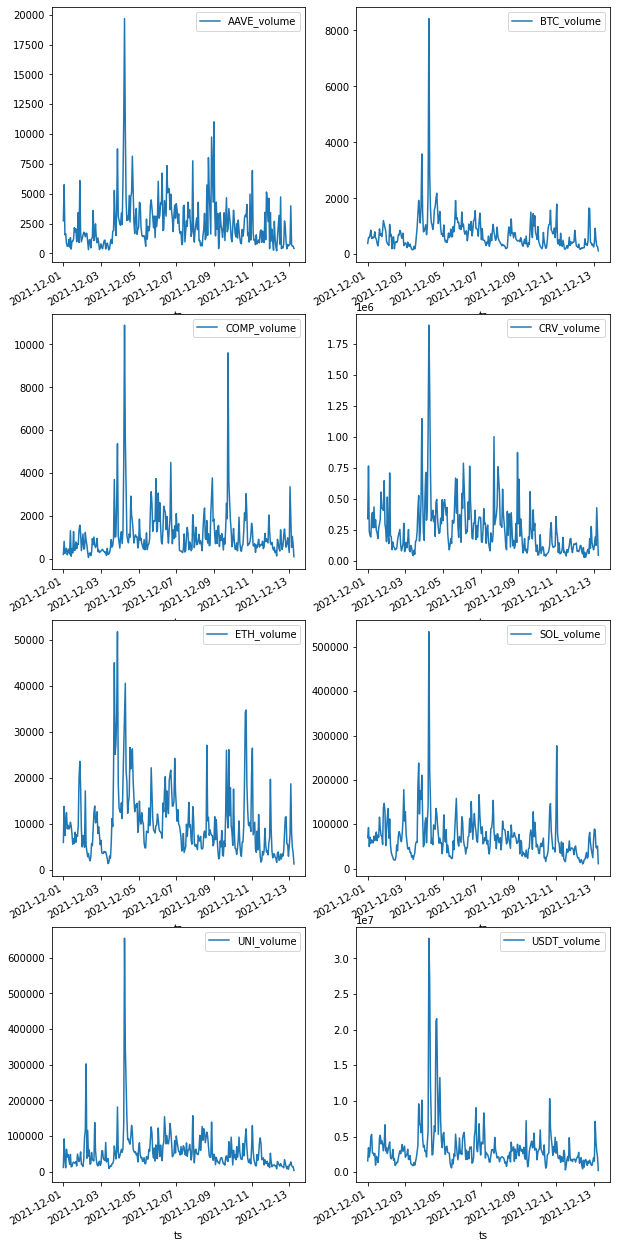

In [25]:
create_graphs(df, ('volume', ))

## Calculating VolumeUSD

In [26]:
df = df.assign(volumeUSD=df['close'] * df['volume'])
df.head()

,open,high,low,close,volume,volumeUSD,token,chain
ts,,,,,,,,
2021-12-01,210.3120,NaN,208.4320,208.6760,70031.618000,1.461392e+07,SOL,SOL
2021-12-01,280.5900,281.4000,278.3000,278.7000,207.849000,5.792752e+04,COMP,ETH
2021-12-01,257.1020,260.7750,255.3450,257.0780,2730.299000,7.018998e+05,AAVE,ETH
2021-12-01,21.2004,21.3115,21.0337,21.2659,12406.133674,2.638276e+05,UNI,ETH
2021-12-01,57321.4100,57451.0500,56814.3400,56987.9700,388.482022,2.213880e+07,BTC,BTC


In [27]:
df.describe()

,open,high,low,close,volume,volumeUSD
count,2327.000000,1901.000000,2081.000000,2327.000000,2.327000e+03,2.327000e+03
mean,7049.101715,6980.459035,6930.786637,7045.733393,4.688498e+05,1.244628e+07
std,16825.516234,16823.647371,16621.917786,16817.247822,1.612079e+06,2.280748e+07
min,1.000200,1.000400,1.000200,1.000300,6.717800e+01,1.819785e+04
25%,15.335000,5.033600,5.253700,15.345000,1.326168e+03,4.601480e+05
50%,190.551000,192.373000,187.924000,190.436000,1.757322e+04,1.822209e+06
75%,3892.740000,284.890000,3835.000000,3901.130000,1.051674e+05,1.583420e+07
max,58664.400000,58783.160000,58445.530000,58664.400000,3.282850e+07,4.029028e+08


## Explore volumeUSD

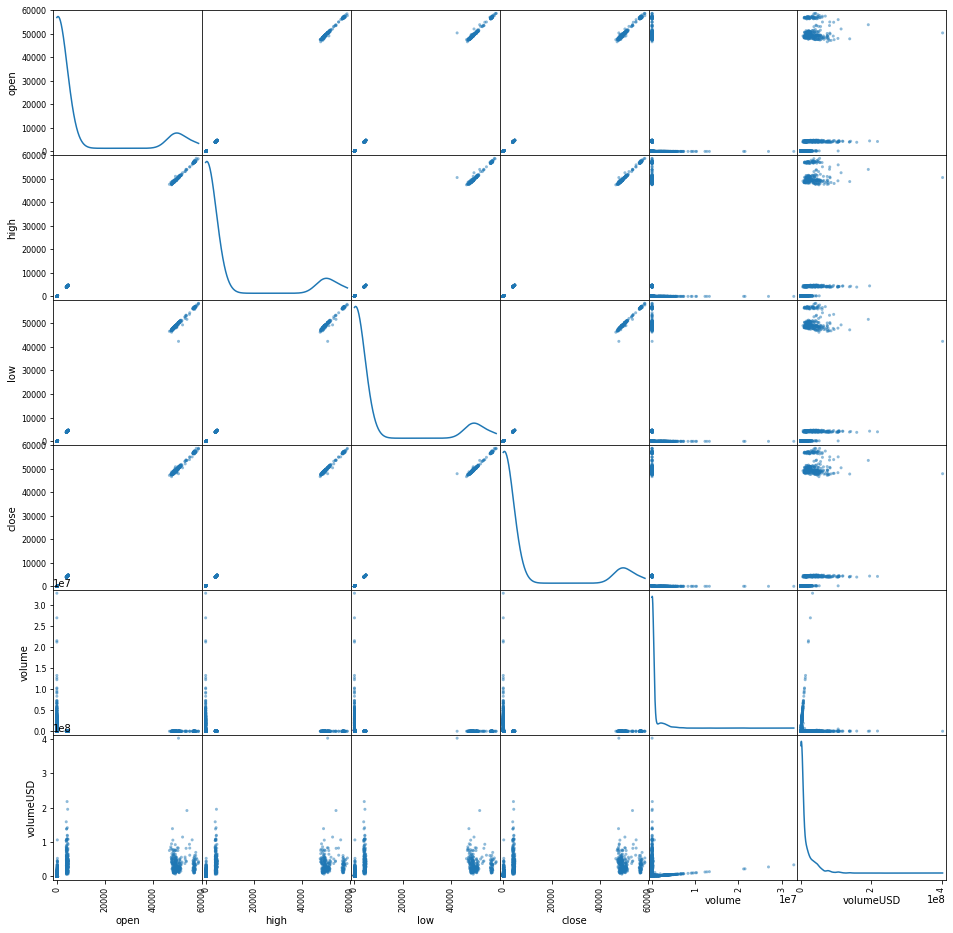

In [28]:
scatter_matrix(df, diagonal='density', figsize=(16,16));

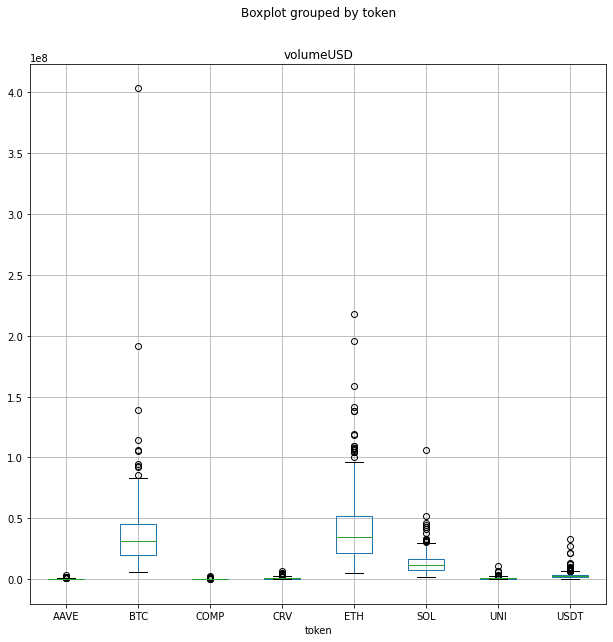

In [29]:
df.boxplot(column='volumeUSD', by='token', figsize=(10,10));

<AxesSubplot:title={'center':'Mean VolumeUSD by Token'}, xlabel='token'>

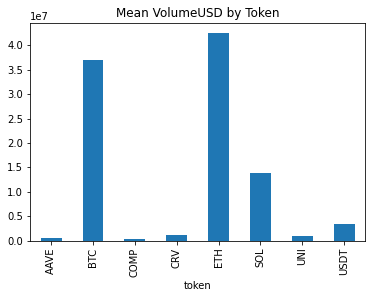

In [30]:
df.groupby('token')['volumeUSD'].mean().plot(kind='bar', title='Mean VolumeUSD by Token')